<a href="https://www.nvidia.com/dli"> <img src="images/DLI Header.png" alt="Header" style="width: 400px;"/> </a>

In [1]:
import datetime
import os

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import (
    Flatten, Dense, Reshape, Conv2D, MaxPool2D, Conv2DTranspose, Input, Dropout, MaxPooling2D, concatenate, BatchNormalization)
import matplotlib.pyplot as plt

plt.rcParams['image.cmap'] = 'Greys_r'

In [2]:
# loading the training and test sets from TFRecords
raw_training_dataset = tf.data.TFRecordDataset('data/train_images.tfrecords')
raw_val_dataset      = tf.data.TFRecordDataset('data/val_images.tfrecords')

In [3]:
# dictionary describing the fields stored in TFRecord, and used to extract the date from the TFRecords
image_feature_description = {
    'height':    tf.io.FixedLenFeature([], tf.int64),
    'width':     tf.io.FixedLenFeature([], tf.int64),
    'depth':     tf.io.FixedLenFeature([], tf.int64),
    'name' :     tf.io.FixedLenFeature([], tf.string),
    'image_raw': tf.io.FixedLenFeature([], tf.string),
    'label_raw': tf.io.FixedLenFeature([], tf.string),
}

In [4]:
# helper function to extract an image from the dictionary
def _parse_image_function(example_proto):
    return tf.io.parse_single_example(example_proto, image_feature_description)

parsed_training_dataset = raw_training_dataset.map(_parse_image_function)
parsed_val_dataset      = raw_val_dataset.map(_parse_image_function)

In [5]:
print(len(list(parsed_training_dataset)))
print(len(list(parsed_val_dataset)))

234
26


In [6]:
# function to read and decode an example from the parsed dataset
@tf.function
def read_and_decode(example):
    image_raw = tf.io.decode_raw(example['image_raw'], tf.int64)
    image_raw.set_shape([65536])
    image = tf.reshape(image_raw, [256, 256, 1])

    image = tf.cast(image, tf.float32) * (1. / 1024)

    label_raw = tf.io.decode_raw(example['label_raw'], tf.uint8)
    label_raw.set_shape([65536])
    label = tf.reshape(label_raw, [256, 256, 1])

    return image, label

In [7]:
# get datasets read and decoded, and into a state usable by TensorFlow
tf_autotune = tf.data.experimental.AUTOTUNE
train = parsed_training_dataset.map(
    read_and_decode, num_parallel_calls=tf_autotune)
val = parsed_val_dataset.map(read_and_decode)
train.element_spec

(TensorSpec(shape=(256, 256, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(256, 256, 1), dtype=tf.uint8, name=None))

In [8]:
# setup the buffer size and batch size for data reading and training
BUFFER_SIZE = 10
BATCH_SIZE = 1
#BATCH_SIZE = 16

In [9]:
# setup the train and test data by shuffling, prefetching, etc
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf_autotune)
test_dataset  = val.batch(BATCH_SIZE)
train_dataset

<PrefetchDataset shapes: ((None, 256, 256, 1), (None, 256, 256, 1)), types: (tf.float32, tf.uint8)>

In [10]:
# helper function to display an image, it's label and the prediction
def display(display_list):
    plt.figure(figsize=(10, 10))
    title = ['Input Image', 'Label', 'Predicted Label']

    for i in range(len(display_list)):
        display_resized = tf.reshape(display_list[i], [256, 256])
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(display_resized)
        plt.axis('off')
    plt.show()

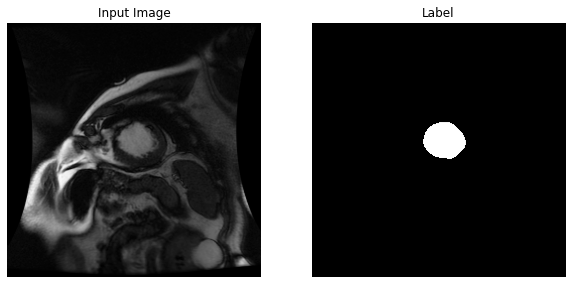

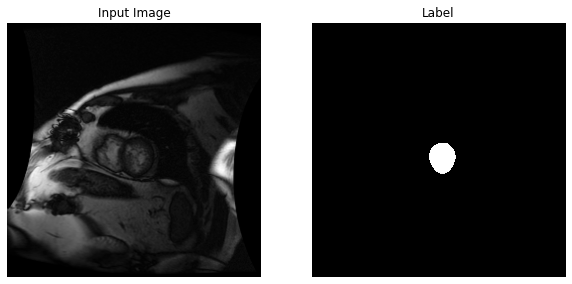

In [11]:
# display an image and label from the training set
for image, label in train.take(2):
    sample_image, sample_label = image, label
    display([sample_image, sample_label])

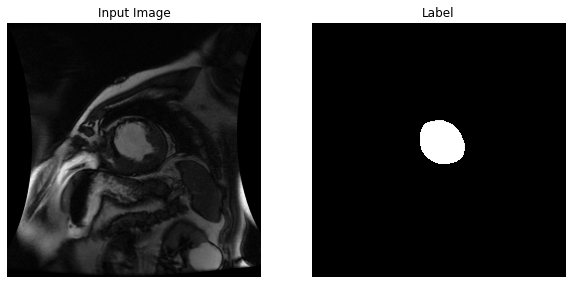

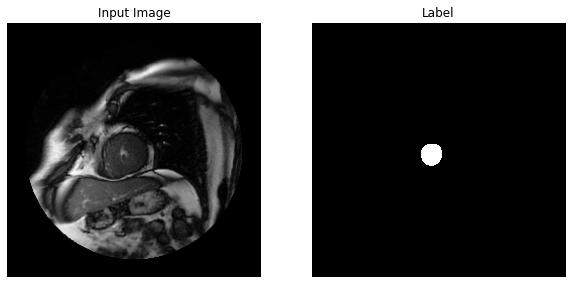

In [12]:
# display an image and label from the test set
for image, label in val.take(2):
    sample_image, sample_label = image, label
    display([sample_image, sample_label])

In [13]:
# function to take a prediction from the model and output an image for display
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [14]:
# helper function to show the image, the label and the prediction
def show_predictions(dataset=None, num=1):
    if dataset:
        for image, label in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], label[0], create_mask(pred_mask)])
    else:
        prediction = create_mask(model.predict(sample_image[tf.newaxis, ...]))
        display([sample_image, sample_label, prediction])

In [15]:
# define a callback that shows image predictions on the test set
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

# setup a tensorboard callback
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

In [17]:
%load_ext tensorboard

In [18]:
%tensorboard --logdir logs

In [150]:
def get_mdl():
    inputs = Input(shape=img_size + (1,))
    #x = Conv2D(input_shape=[256, 256, 1],
    x = Conv2D(filters=100,
           kernel_size=5,
           strides=2,
           padding="same",
           activation=tf.nn.relu,
           name="Conv1")(inputs)
    x = MaxPool2D(pool_size=2, strides=2, padding="same")(x)
    x = Conv2D(filters=200,
           kernel_size=5,
           strides=2,
           padding="same",
           activation=tf.nn.relu)(x)
    x = MaxPool2D(pool_size=2, strides=2, padding="same")(x)
    x = Conv2D(filters=300,
           kernel_size=3,
           strides=1,
           padding="same",
           activation=tf.nn.relu)(x)
    x = Conv2D(filters=300,
           kernel_size=3,
           strides=1,
           padding="same",
           activation=tf.nn.relu)(x)
    x = Conv2D(filters=2,
           kernel_size=1,
           strides=1,
           padding="same",
           activation=tf.nn.relu)(x)
    conv10 = Conv2DTranspose(filters=2, kernel_size=31, strides=16, padding="same")(x)
    
    model = tf.keras.Model(inputs=[inputs], outputs=[conv10])
    return model

#model = tf.keras.models.Sequential(get_mdl)
tf.keras.backend.clear_session()
model = get_mdl()
#model.compile(
#    optimizer='adam',
#    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#    metrics=['accuracy'])

In [151]:
# print out the summary of the model
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 1)]     0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 128, 128, 100)     2600      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 100)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 200)       500200    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 200)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 300)       540300    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 300)       810300

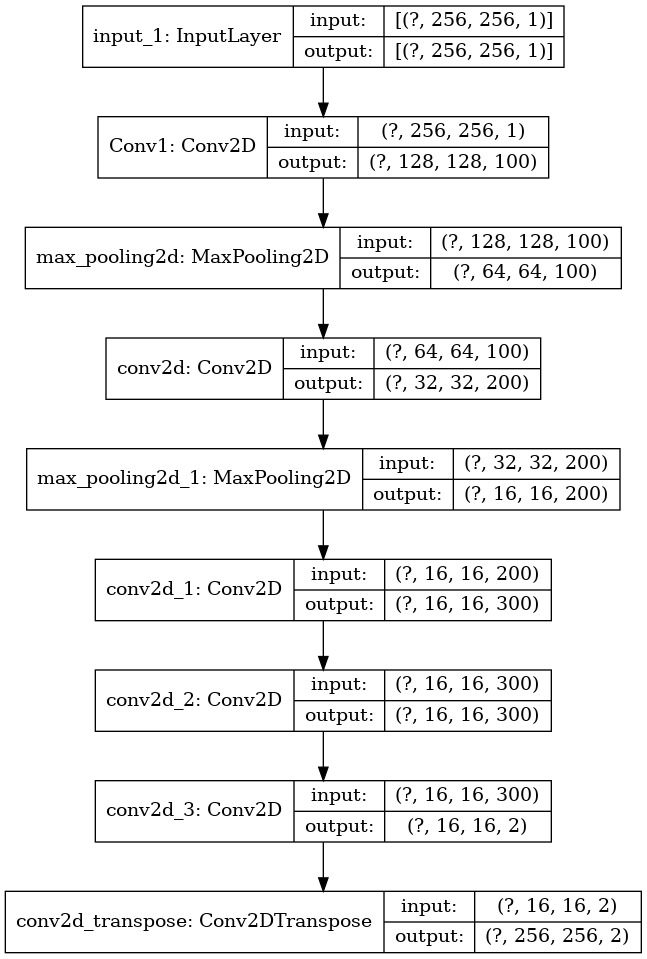

In [152]:
# plot the model including the sizes of the model
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.evaluate(test_dataset)

In [ ]:
# show predictions from the test data set that has NOT been used for training.
show_predictions(test_dataset, 5)

In [16]:
def dice_coef(y_true, y_pred, smooth=1):
    indices = K.argmax(y_pred, 3)
    indices = K.reshape(indices, [-1, 256, 256, 1])

    true_cast = y_true
    indices_cast = K.cast(indices, dtype='float32')

    axis = [1, 2, 3]
    intersection = K.sum(true_cast * indices_cast, axis=axis)
    union = K.sum(true_cast, axis=axis) + K.sum(indices_cast, axis=axis)
    dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)

    return dice

In [43]:
#tf.keras.backend.clear_session() 
#model = tf.keras.models.Sequential(layers)

In [39]:
opt = 'adam'
#opt = 'sgd'
model.compile(
    optimizer=opt,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    #loss='binary_crossentropy',
    metrics=[dice_coef,'accuracy'])

In [40]:
 # setup and run the model
EPOCHS = 30
STEPS_PER_EPOCH = len(list(parsed_training_dataset))

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()])

Epoch 1/30


ValueError: in user code:

    /home/jeff/anaconda3/envs/tf-seg-123120/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:571 train_function  *
        outputs = self.distribute_strategy.run(
    /home/jeff/anaconda3/envs/tf-seg-123120/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:951 run  **
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/jeff/anaconda3/envs/tf-seg-123120/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2290 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/jeff/anaconda3/envs/tf-seg-123120/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2649 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/jeff/anaconda3/envs/tf-seg-123120/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:543 train_step  **
        self.compiled_metrics.update_state(y, y_pred, sample_weight)
    /home/jeff/anaconda3/envs/tf-seg-123120/lib/python3.8/site-packages/tensorflow/python/keras/engine/compile_utils.py:411 update_state
        metric_obj.update_state(y_t, y_p)
    /home/jeff/anaconda3/envs/tf-seg-123120/lib/python3.8/site-packages/tensorflow/python/keras/utils/metrics_utils.py:90 decorated
        update_op = update_state_fn(*args, **kwargs)
    /home/jeff/anaconda3/envs/tf-seg-123120/lib/python3.8/site-packages/tensorflow/python/keras/metrics.py:603 update_state
        matches = self._fn(y_true, y_pred, **self._fn_kwargs)
    /home/jeff/anaconda3/envs/tf-seg-123120/lib/python3.8/site-packages/tensorflow/python/keras/metrics.py:3252 sparse_categorical_accuracy
        return math_ops.cast(math_ops.equal(y_true, y_pred), K.floatx())
    /home/jeff/anaconda3/envs/tf-seg-123120/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:180 wrapper
        return target(*args, **kwargs)
    /home/jeff/anaconda3/envs/tf-seg-123120/lib/python3.8/site-packages/tensorflow/python/ops/math_ops.py:1445 equal
        return gen_math_ops.equal(x, y, name=name)
    /home/jeff/anaconda3/envs/tf-seg-123120/lib/python3.8/site-packages/tensorflow/python/ops/gen_math_ops.py:3222 equal
        _, _, _op, _outputs = _op_def_library._apply_op_helper(
    /home/jeff/anaconda3/envs/tf-seg-123120/lib/python3.8/site-packages/tensorflow/python/framework/op_def_library.py:742 _apply_op_helper
        op = g._create_op_internal(op_type_name, inputs, dtypes=None,
    /home/jeff/anaconda3/envs/tf-seg-123120/lib/python3.8/site-packages/tensorflow/python/framework/func_graph.py:593 _create_op_internal
        return super(FuncGraph, self)._create_op_internal(  # pylint: disable=protected-access
    /home/jeff/anaconda3/envs/tf-seg-123120/lib/python3.8/site-packages/tensorflow/python/framework/ops.py:3319 _create_op_internal
        ret = Operation(
    /home/jeff/anaconda3/envs/tf-seg-123120/lib/python3.8/site-packages/tensorflow/python/framework/ops.py:1816 __init__
        self._c_op = _create_c_op(self._graph, node_def, inputs,
    /home/jeff/anaconda3/envs/tf-seg-123120/lib/python3.8/site-packages/tensorflow/python/framework/ops.py:1657 _create_c_op
        raise ValueError(str(e))

    ValueError: Dimensions must be equal, but are 256 and 64 for '{{node Equal}} = Equal[T=DT_FLOAT, incompatible_shape_error=true](Squeeze, Cast_5)' with input shapes: [?,256,256], [?,64,64].


In [ ]:
# output model statistics
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
accuracy = model_history.history['accuracy']
val_accuracy = model_history.history['val_accuracy']
dice = model_history.history['dice_coef']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.plot(epochs, dice, 'go', label='Dice Coefficient')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()


In [34]:
scc_loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)


In [17]:
#tf.keras.backend.clear_session()
img_rows = 256
img_cols = 256
img_size = (256,256)

In [33]:


def get_unet():
    #inputs = Input((img_rows, img_cols, 1))
    inputs = Input(shape=img_size + (1,))
    conv1 = Conv2D(32, (3, 3), activation=tf.nn.relu, padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation=tf.nn.relu, padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation=tf.nn.relu, padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation=tf.nn.relu, padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv10 = Conv2D(2, (1, 1), activation='sigmoid')(pool2)

    conv3 = Conv2D(128, (3, 3), activation=tf.nn.relu, padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation=tf.nn.relu, padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation=tf.nn.relu, padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation=tf.nn.relu, padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation=tf.nn.relu, padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation=tf.nn.relu, padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation=tf.nn.relu, padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation=tf.nn.relu, padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation=tf.nn.relu, padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation=tf.nn.relu, padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation=tf.nn.relu, padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation=tf.nn.relu, padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation=tf.nn.relu, padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation=tf.nn.relu, padding='same')(conv9)

    #conv9 = Conv2D(2, (3, 3), activation=tf.nn.relu, padding='same')(conv9)
    
    conv10 = Conv2D(2, (1, 1), activation='sigmoid')(conv9)

    model = tf.keras.Model(inputs=[inputs], outputs=[conv10])
    #optimizer = tf.keras.optimizers.Adam(lr=1e-3)
    #model.compile(optimizer=Adam(lr=1e-3), loss=dice_coef_loss, metrics=[dice_coef])
    #model.compile(optimizer, loss=dice_coef_loss, metrics=[dice_coef])

    return model

# Free up RAM in case the model definition cells were run multiple times
tf.keras.backend.clear_session()

#model = tf.keras.models.Sequential(layers)
model = get_unet()



In [130]:

out = 0.85
def get_umodel():
    #inputs = Input((img_rows, img_cols, 1))
    inputs = Input(shape=img_size + (1,))
    conv1 = Conv2D(32, (3, 3), activation=tf.nn.relu, padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation=tf.nn.relu, padding='same')(conv1)
    conv1 = Dropout(out)(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    

    conv2 = Conv2D(64, (3, 3), activation=tf.nn.relu, padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation=tf.nn.relu, padding='same')(conv2)
    conv2 = Dropout(out)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    

    conv3 = Conv2D(128, (3, 3), activation=tf.nn.relu, padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation=tf.nn.relu, padding='same')(conv3)
    conv3 = Dropout(out)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    

    conv4 = Conv2D(256, (3, 3), activation=tf.nn.relu, padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation=tf.nn.relu, padding='same')(conv4)
    conv4 = Dropout(out)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    

    conv5 = Conv2D(512, (3, 3), activation=tf.nn.relu, padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation=tf.nn.relu, padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation=tf.nn.relu, padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation=tf.nn.relu, padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation=tf.nn.relu, padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation=tf.nn.relu, padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation=tf.nn.relu, padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation=tf.nn.relu, padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation=tf.nn.relu, padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation=tf.nn.relu, padding='same')(conv9)

    #conv9 = Conv2D(2, (3, 3), activation=tf.nn.relu, padding='same')(conv9)
    
    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = tf.keras.Model(inputs=[inputs], outputs=[conv10])
    #optimizer = tf.keras.optimizers.Adam(lr=1e-3)
    #model.compile(optimizer=Adam(lr=1e-3), loss=dice_coef_loss, metrics=[dice_coef])
    #model.compile(optimizer, loss=dice_coef_loss, metrics=[dice_coef])

    return model

# Free up RAM in case the model definition cells were run multiple times
tf.keras.backend.clear_session()

#model = tf.keras.models.Sequential(layers)
model = get_umodel()



In [144]:

def unet(pretrained_weights = None,input_size = (256,256,1)):
    #inputs = Input(input_size)
    inputs = Input(shape=img_size + (1,))
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(2, 1, activation = 'sigmoid')(conv9)

    model = Model(input = inputs, output = conv10)

    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = [dice_loss,'accuracy'])
    
    #model.summary()

    if(pretrained_weights):
        model.load_weights(pretrained_weights)

    return model

model = get_unet()


In [ ]:
#model_1.summary()

In [ ]:
#tf.keras.utils.plot_model(model_1, show_shapes=True)

In [50]:
#model = model_1
#model = model_2

In [42]:
losses = scc_loss
#losses = dice_coef_loss
model.compile(
    optimizer='adam',
    loss=losses,
    metrics=[dice_coef,'accuracy'])

In [40]:
EPOCHS = 30
STEPS_PER_EPOCH = len(list(parsed_training_dataset))

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()])

Epoch 1/30


ValueError: in user code:

    /home/jeff/anaconda3/envs/tf-seg-123120/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:571 train_function  *
        outputs = self.distribute_strategy.run(
    /home/jeff/anaconda3/envs/tf-seg-123120/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:951 run  **
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/jeff/anaconda3/envs/tf-seg-123120/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2290 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/jeff/anaconda3/envs/tf-seg-123120/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2649 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/jeff/anaconda3/envs/tf-seg-123120/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:540 train_step  **
        _minimize(self.distribute_strategy, tape, self.optimizer, loss,
    /home/jeff/anaconda3/envs/tf-seg-123120/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1803 _minimize
        gradients = optimizer._aggregate_gradients(zip(gradients,  # pylint: disable=protected-access
    /home/jeff/anaconda3/envs/tf-seg-123120/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:521 _aggregate_gradients
        filtered_grads_and_vars = _filter_grads(grads_and_vars)
    /home/jeff/anaconda3/envs/tf-seg-123120/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:1218 _filter_grads
        raise ValueError("No gradients provided for any variable: %s." %

    ValueError: No gradients provided for any variable: ['conv2d/kernel:0', 'conv2d/bias:0', 'batch_normalization/gamma:0', 'batch_normalization/beta:0', 'separable_conv2d/depthwise_kernel:0', 'separable_conv2d/pointwise_kernel:0', 'separable_conv2d/bias:0', 'batch_normalization_1/gamma:0', 'batch_normalization_1/beta:0', 'separable_conv2d_1/depthwise_kernel:0', 'separable_conv2d_1/pointwise_kernel:0', 'separable_conv2d_1/bias:0', 'batch_normalization_2/gamma:0', 'batch_normalization_2/beta:0', 'conv2d_1/kernel:0', 'conv2d_1/bias:0', 'separable_conv2d_2/depthwise_kernel:0', 'separable_conv2d_2/pointwise_kernel:0', 'separable_conv2d_2/bias:0', 'batch_normalization_3/gamma:0', 'batch_normalization_3/beta:0', 'separable_conv2d_3/depthwise_kernel:0', 'separable_conv2d_3/pointwise_kernel:0', 'separable_conv2d_3/bias:0', 'batch_normalization_4/gamma:0', 'batch_normalization_4/beta:0', 'conv2d_2/kernel:0', 'conv2d_2/bias:0', 'separable_conv2d_4/depthwise_kernel:0', 'separable_conv2d_4/pointwise_kernel:0', 'separable_conv2d_4/bias:0', 'batch_normalization_5/gamma:0', 'batch_normalization_5/beta:0', 'separable_conv2d_5/depthwise_kernel:0', 'separable_conv2d_5/pointwise_kernel:0', 'separable_conv2d_5/bias:0', 'batch_normalization_6/gamma:0', 'batch_normalization_6/beta:0', 'conv2d_3/kernel:0', 'conv2d_3/bias:0', 'conv2d_transpose/kernel:0', 'conv2d_transpose/bias:0', 'batch_normalization_7/gamma:0', 'batch_normalization_7/beta:0', 'conv2d_transpose_1/kernel:0', 'conv2d_transpose_1/bias:0', 'batch_normalization_8/gamma:0', 'batch_normalization_8/beta:0', 'conv2d_4/kernel:0', 'conv2d_4/bias:0', 'conv2d_transpose_2/kernel:0', 'conv2d_transpose_2/bias:0', 'batch_normalization_9/gamma:0', 'batch_normalization_9/beta:0', 'conv2d_transpose_3/kernel:0', 'conv2d_transpose_3/bias:0', 'batch_normalization_10/gamma:0', 'batch_normalization_10/beta:0', 'conv2d_5/kernel:0', 'conv2d_5/bias:0', 'conv2d_transpose_4/kernel:0', 'conv2d_transpose_4/bias:0', 'batch_normalization_11/gamma:0', 'batch_normalization_11/beta:0', 'conv2d_transpose_5/kernel:0', 'conv2d_transpose_5/bias:0', 'batch_normalization_12/gamma:0', 'batch_normalization_12/beta:0', 'conv2d_6/kernel:0', 'conv2d_6/bias:0', 'conv2d_transpose_6/kernel:0', 'conv2d_transpose_6/bias:0', 'batch_normalization_13/gamma:0', 'batch_normalization_13/beta:0', 'conv2d_transpose_7/kernel:0', 'conv2d_transpose_7/bias:0', 'batch_normalization_14/gamma:0', 'batch_normalization_14/beta:0', 'conv2d_7/kernel:0', 'conv2d_7/bias:0', 'conv2d_8/kernel:0', 'conv2d_8/bias:0'].


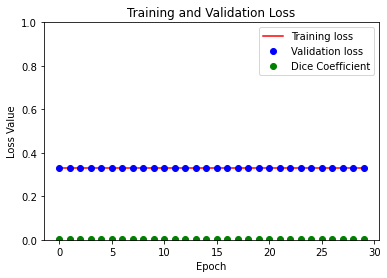

In [56]:
# output model statistics
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
accuracy = model_history.history['accuracy']
val_accuracy = model_history.history['val_accuracy']
dice = model_history.history['dice_coef']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.plot(epochs, dice, 'go', label='Dice Coefficient')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()